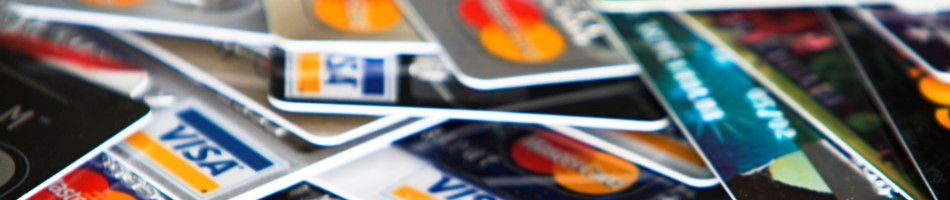

**Description du projet**

L'objectif de ce projet est de construire un modèle de détection de fraude bancaire en
utilisant Spark ML. Le modèle prendra en entrée un ensemble de caractéristiques liées
à une transaction (par exemple, le montant de la transaction, le pays de l'émetteur, le
type de carte, etc.) et prédira si la transaction est frauduleuse ou non.

---

**Source des données**

Source des données :
Pour ce projet, nous pouvons utiliser l'ensemble de données de fraude de carte de crédit de
Kaggle, disponible à l'adresse suivante: https://www.kaggle.com/mlg-ulb/creditcardfraud.

In [1]:
#Bibliothèque

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


# 1. Exploration des données


In [2]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
37717,39076,1.117749,-1.544665,-0.145357,-1.307482,-1.392833,-0.630833,-0.563659,-0.038716,-2.173892,...,-0.334155,-1.108220,0.070461,0.115485,0.078726,-0.460844,-0.029143,0.029028,183.19,0.0
37718,39076,0.758729,-0.483875,0.125488,1.449159,-0.639231,-0.805011,0.406994,-0.221212,0.068777,...,0.210712,0.063091,-0.316636,0.394472,0.558720,-0.304812,-0.033008,0.063331,250.00,0.0
37719,39076,-0.474907,0.835804,0.075878,-1.251283,2.492736,3.385419,0.169507,0.934749,-0.584224,...,-0.270398,-0.866353,-0.085720,0.986274,-0.082934,0.084198,0.310936,0.170342,1.49,0.0
37720,39077,-2.682780,-2.028562,1.745223,-1.157952,-0.143692,-0.807503,-1.154141,0.436917,-0.293442,...,0.353396,0.968145,-0.776459,0.182662,-0.000427,-0.209058,0.256991,-0.585781,102.00,0.0
37721,39077,1.106292,-0.525727,0.926440,0.817696,-1.122177,-0.062703,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La commande *df.info()* nous renseigne sur les informations de notre jeu de données. Nous remarquons qu'il **284807** observations. Nous observons que notre jeu de données ne contient pas de valeurs manquantes (non-null).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Nous obtenons le même résultat que sur la commande précédente ce qui est en somme un bon jeu de donées. Nous pourrons supprimer cette ligne au niveau de l'étape **2. Préparation des données**

In [ ]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Il serait interessant de recupérer un échantillon aléatoire sans remise de 10 lignes afin de pouvoir voir àl'oeil nu les abérations qui sont peut être cachées au niveau des varibales par exemple un point d'interrogation "?" ou autres symboles.

In [ ]:
df.isnull().sum().max()

0

In [ ]:
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
128454,78716.0,1.159678,-1.519168,0.771387,-1.339257,-1.763734,-0.066396,-1.224297,0.065471,-1.979790,...,0.114060,0.489352,-0.074301,0.251836,0.185727,-0.119323,0.045396,0.038691,136.00,0
67516,52574.0,1.179656,-1.337487,0.959881,-1.943711,-2.326174,-1.369785,-1.029789,-0.077941,0.918828,...,-0.175474,-0.173921,0.050134,0.882980,0.081308,-0.126363,0.049226,0.051985,94.88,0
239418,150102.0,1.972557,-0.772242,-1.329721,-2.216561,0.188889,0.429508,-0.442331,0.247459,2.383426,...,-0.371555,-0.736723,0.537090,-0.410759,-0.486023,-1.274190,0.105200,-0.042635,2.24,0
131675,79693.0,-2.241365,2.324377,1.949202,-0.886628,0.636661,-0.958163,2.535503,-2.018048,2.970298,...,-1.057661,-0.411882,-0.247145,0.679639,0.101397,-0.213525,-0.517455,-1.653886,9.81,0
19665,30450.0,-2.529616,-1.243665,1.117035,1.539817,0.443499,-0.466238,-0.599368,0.535079,-0.211998,...,-0.134050,0.245857,1.118719,0.055627,0.707826,0.876338,-0.263795,0.026698,19.24,0
39846,39992.0,1.207099,-0.300112,-0.311003,0.164989,1.543265,4.058650,-1.140805,1.090853,0.761328,...,-0.115422,-0.279335,-0.040503,1.001063,0.573693,-0.393611,0.074648,0.031567,9.99,0
150708,93940.0,-0.142134,-0.988516,-2.783206,-0.874696,2.108458,3.618224,1.390964,0.278595,-1.153660,...,0.112358,0.463027,0.747621,0.740503,-0.519179,1.912419,-0.005432,0.217307,378.90,0
46122,42646.0,0.040329,-1.584080,-0.276400,1.674685,-0.717064,-0.187298,0.854463,-0.224464,-0.112272,...,0.460657,0.066401,-0.606331,0.125594,0.387887,-0.315424,-0.076756,0.122768,599.88,0
171726,120787.0,2.076952,-1.097748,0.133994,-0.483005,-1.316604,0.322204,-1.526483,0.134183,0.368411,...,-0.159195,0.182367,0.305906,0.508332,-0.590809,0.604624,0.028637,-0.021198,22.25,0
40542,40285.0,0.758244,-0.403836,-0.055171,1.306383,0.030989,0.452411,0.260819,0.171878,-0.152502,...,0.176561,0.265512,-0.252874,-0.276621,0.576206,-0.236324,0.000753,0.027224,185.04,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df['Class'].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
#Distribution des cas de fraudes et non fraudes
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [ ]:
#Fréquence de distribution des cas de fraudes et non fraudes
print('No Fraud', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraud', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Fraud 99.83 % of the dataset
Fraud 0.17 % of the dataset


En observant ce graphique nous observons qu'il y a un déséquilibre au niveau du jeu de données. Il y a majoritairement plus de non fraude que de fraudes. En utilisant le jeu de données tel quel, nos algorithmes d'apprentissage auraient tendance à prédire qu'il n'y a pas de fraudes.

<ipython-input-13-57d5e1d06a83>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette=colors)


Text(0.5, 1.0, 'Distributions de Class \n (0: No Fraud || 1: Fraud)')

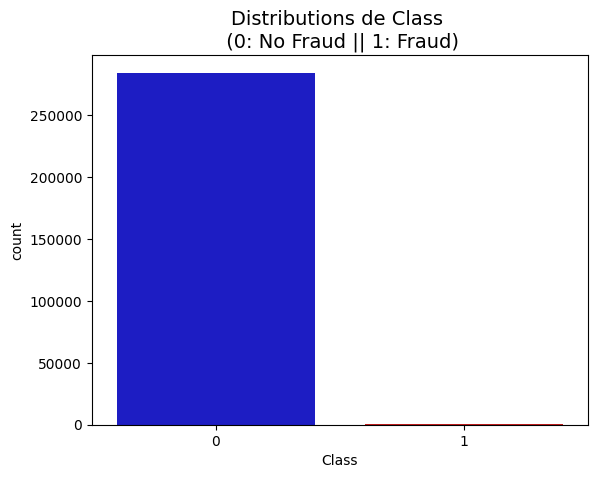

In [ ]:
#Repartition des cas de fraudes et non fraudes
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Distributions de Class \n (0: No Fraud || 1: Fraud)', fontsize=14)

<Axes: xlabel='Time', ylabel='Count'>

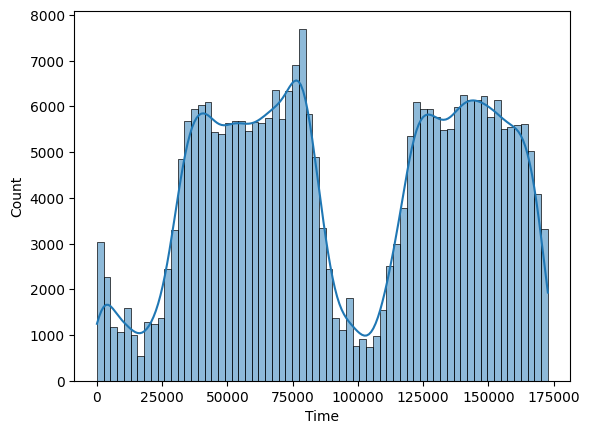

In [ ]:
sns.histplot(df['Time'], kde=True)

<Axes: >

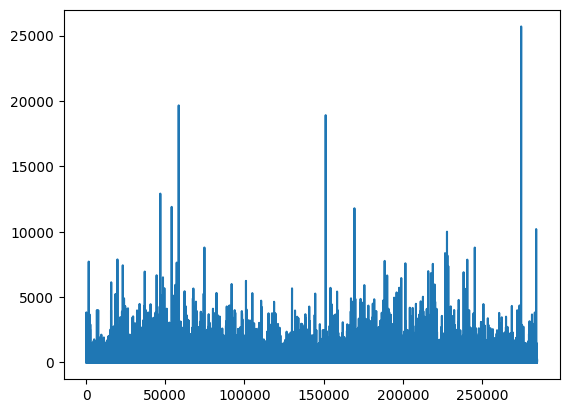

In [ ]:
df['Amount'].plot()

In [ ]:
df['Class'].dtype

dtype('int64')

In [ ]:
df['Class'].unique()

array([0, 1])

# 2. Préparation des données

Nous avons pu observer que notre dataset est déséquilibré, en effet, il y a 0.17% de cas de fraude pour 99.83 % de cas de non fraude.

Nous devons pour cela créer un échantillon de notre dataset afin d'avoir un nombre égal de cas de fraude et de cas de non-fraude, dans le but que nos algorithmes comprennent mieux et arrivent à prédire les cas de fraude et non fraude.

**❗Quelle est l'importance de créer un échantillon ?**

Le dataset de départ étant largement déséquilibré, se servir de ce dataset pour créer un modèle conduira des problèmes d'**overfitting**
Nos modèles prédiront que dans la plupart des cas, il n'y a pas de fraude ! Notre souhait, c'est être certain qu'une fraude se produit.

***overfitting*** : *Le surajustement est un comportement indésirable d'apprentissage automatique qui se produit lorsque le modèle d'apprentissage automatique fournit des prédictions précises pour les données d'entraînement mais pas pour les nouvelles données*

[*Source : Amazon Web Services*](https://aws.amazon.com/fr/what-is/overfitting/)

Les variables *V* proviennent d'une **ACP** (Analyse en composantes Principales) ont déjà été normalisées nous allons poursuivre la normalisation des données en mettant à l'échelle le reste des variables (Amount, Time) en se servant des fonctions **StandardScaler** et **RobustScaler** de la bibliothèque **sklearn.preprocessing**. La mise à l'échelle est importante car de nombreuses méthodes d'apprentissage automatique fonctionnent mieux lorsque les caractéristiques sont à peu près à la même échelle.

*StandardScaler : Cette fonction effectue une mise à l'échelle des fonctionnalités en retirant la moyenne et en mettant à l'échelle jusqu'à l'unité de variance. Cela signifie que chaque caractéristique (colonne) du jeu de données sera transformée pour avoir une moyenne nulle et une variance unitaire.*

*RobustScaler : Contrairement à StandardScaler, RobustScaler n'utilise pas la moyenne et l'écart type pour mettre à l'échelle les données. Au lieu de cela, il utilise la médiane et l'intervalle interquartile (IQR).
L'avantage du RobustScaler est qu'il est moins sensible aux valeurs aberrantes dans les données que StandardScaler. Les valeurs aberrantes peuvent avoir un impact disproportionné sur la moyenne et l'écart type, mais elles ont moins d'effet sur la médiane et l'IQR.
Cela en fait un choix préféré lorsque vos données sont susceptibles de contenir des valeurs aberrantes ou des erreurs de mesure.*

*Source : ChatGPT*





In [ ]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
#Sauvegarde des colonnes 'scaled_amount' et 'scale_time' dans des variables séparées.
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

#Supprission des colonnes 'scaled_amount' et 'scaled_time' du DataFrame.
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

#Insèrsion des colonnes 'scaled_amount' et 'scaled_time' à la position 0 et 1 du DataFrame.
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Séparation des données
Nous allons séparer les données en données d'entrainement et de test

In [ ]:
#Affichage des fréquences des données frauduleuses et non frauduleuses
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

#Séparation des données en features (X) et en target (y)
X = df.drop('Class', axis=1)
y = df['Class']

#Divisions des données en cinq ensembles train/test stratifiés
#Cette méthode est utilisée suite au déséquilibre important entre les Class de la variable cible
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=None)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Nous avons déjà X_train et y_train pour les données du sous-échantillon, c'est pourquoi j'utilise original pour distinguer et ne pas écraser ces variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation en tableau numpy pour faciliter la manipulation des données
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Vérification si les distributions des étiquettes de formation et de test sont distribuées de manière similaire
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [115143  52755 230257 ... 149742  87834  52074] Test: [ 37932  68191 194642 ...  30556 140373 245599]
Train: [124751 180087  42798 ...   2715 155195  21503] Test: [177869  77348 276344 ...  53267 173230  94710]
Train: [ 31316 120606 270265 ...  87564 266447 158545] Test: [ 27235  95611 117957 ... 139834 147250  48666]
Train: [ 20135  85897 151670 ... 243568 282925 229632] Test: [ 55730 125461  28877 ... 149989 133160 130061]
Train: [148485 131889  45751 ... 110570  79382 122095] Test: [268489  66112  20257 ... 199510  27550 136471]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


Création de l'échantillon pour avoir des distributions de "Fraud" et "Non Fraud" égales

NB:Le revers du tirage aléatoire simple (échantillonage) est que notre modèle ne soit pas aussi précis car nous avons supprimer un partie très importante de nos données. Rappellons ici que l'objectif de l'échantillonnage est de ramener le nombre de cas de "Non Fraud" de **284315** à **492** ce qui veut dire que nous perdons la mojorité des informations du jeu de données.

In [ ]:
'''Mélangeons les données avant de créer les sous-échantillons de s'assurer que
les données ne sont pas dans un ordre spécifique qui pourrait biaiser
l'apprentissage des modèles.'''

df = df.sample(frac=1)

# Séparation des données en deux parties
fraud_df = df.loc[df['Class'] == 1] # Un DataFrame contenant uniquement les lignes où la colonne 'Class' a la valeur 1, c'est-à-dire les transactions frauduleuses.
# Limitation du nombre de transactions non frauduleuses à 492
non_fraud_df = df.loc[df['Class'] == 0][:492] # Un DataFrame contenant uniquement les 492 premières lignes où la colonne 'Class' a la valeur 0, c'est-à-dire les transactions non frauduleuses

# Concatènation de fraud_df et non_fraud_df pour former un nouveau DataFrame appelé normal_distributed_df
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Mélange aléatoirement des lignes du DataFrame 'normal_distributed_df'
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
15571,0.016069,-0.678180,1.214522,0.007067,-0.330466,0.890385,0.669037,1.120938,-0.105341,0.283448,...,-0.143320,-0.163848,-0.334281,-0.291694,-1.710519,0.831878,-0.222015,0.025880,-0.010782,0
46998,2.546915,-0.489479,-1.109646,0.811069,-1.138135,0.935265,-2.330248,-0.116106,-1.621986,0.458028,...,0.168891,0.641594,0.841755,0.176728,0.081004,-0.258899,0.707654,0.418649,0.080756,1
119896,0.179976,-0.106521,1.213038,-1.068433,1.251821,-0.381918,-1.945585,-0.206163,-1.302724,0.280248,...,-0.548682,-0.422290,-0.756156,0.158041,0.521490,-0.131213,0.933653,-0.027923,0.014057,0
30442,-0.243695,-0.572916,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,...,0.757287,1.691042,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,1
191074,9.764550,0.521658,-1.836940,-1.646764,-3.381168,0.473354,0.074243,-0.446751,3.791907,-1.351045,...,-1.586144,0.010663,1.786681,-0.151178,-0.582098,-0.956062,-0.334369,0.715600,0.370450,1


Répartition de la classe Fraud et Non Fraud de l"échantillon
Class
0    0.5
1    0.5
Name: count, dtype: float64


<ipython-input-42-1e42c9c07293>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(new_df, x='Class', palette=colors)


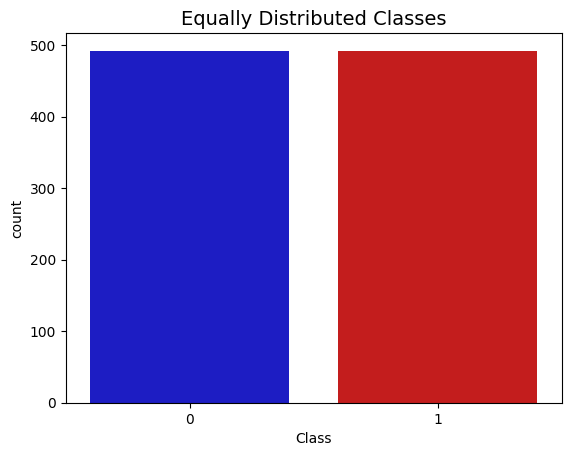

In [ ]:
print('Répartition de la classe Fraud et Non Fraud sur l"échantillon')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(new_df, x='Class', palette=colors)
plt.title('Classes équitablement réparties', fontsize=14)
plt.show()

### Matrice de corrélation

La matrice de corrélation permet de voir l'influence des variables exogènes sur la variable cible "Class".

*   Bleu : corrélation positive
*   Rouge : corrélation négative

**Observations :**
*   Corrélation négative : Les variables V10, V12, V14, V16, V17 et V18 sont corrélés négativement (nous allons garder les variables à forte corrélation V10, V12, V14, V16 et V17 ) à la variable Class, c'est à dire que plus ces valeurs sont faibles (petites) plus la transaction est succeptible d'être un cas de "Fraud"
*   Corrélation positive : Les variables V2, V4, V11 et V19 sont corrélés positivement à la variable Class, c'est à dire que plus ces valeurs sont élévées (grandes) plus la transaction est succeptible d'être un cas de "Non Fraud"



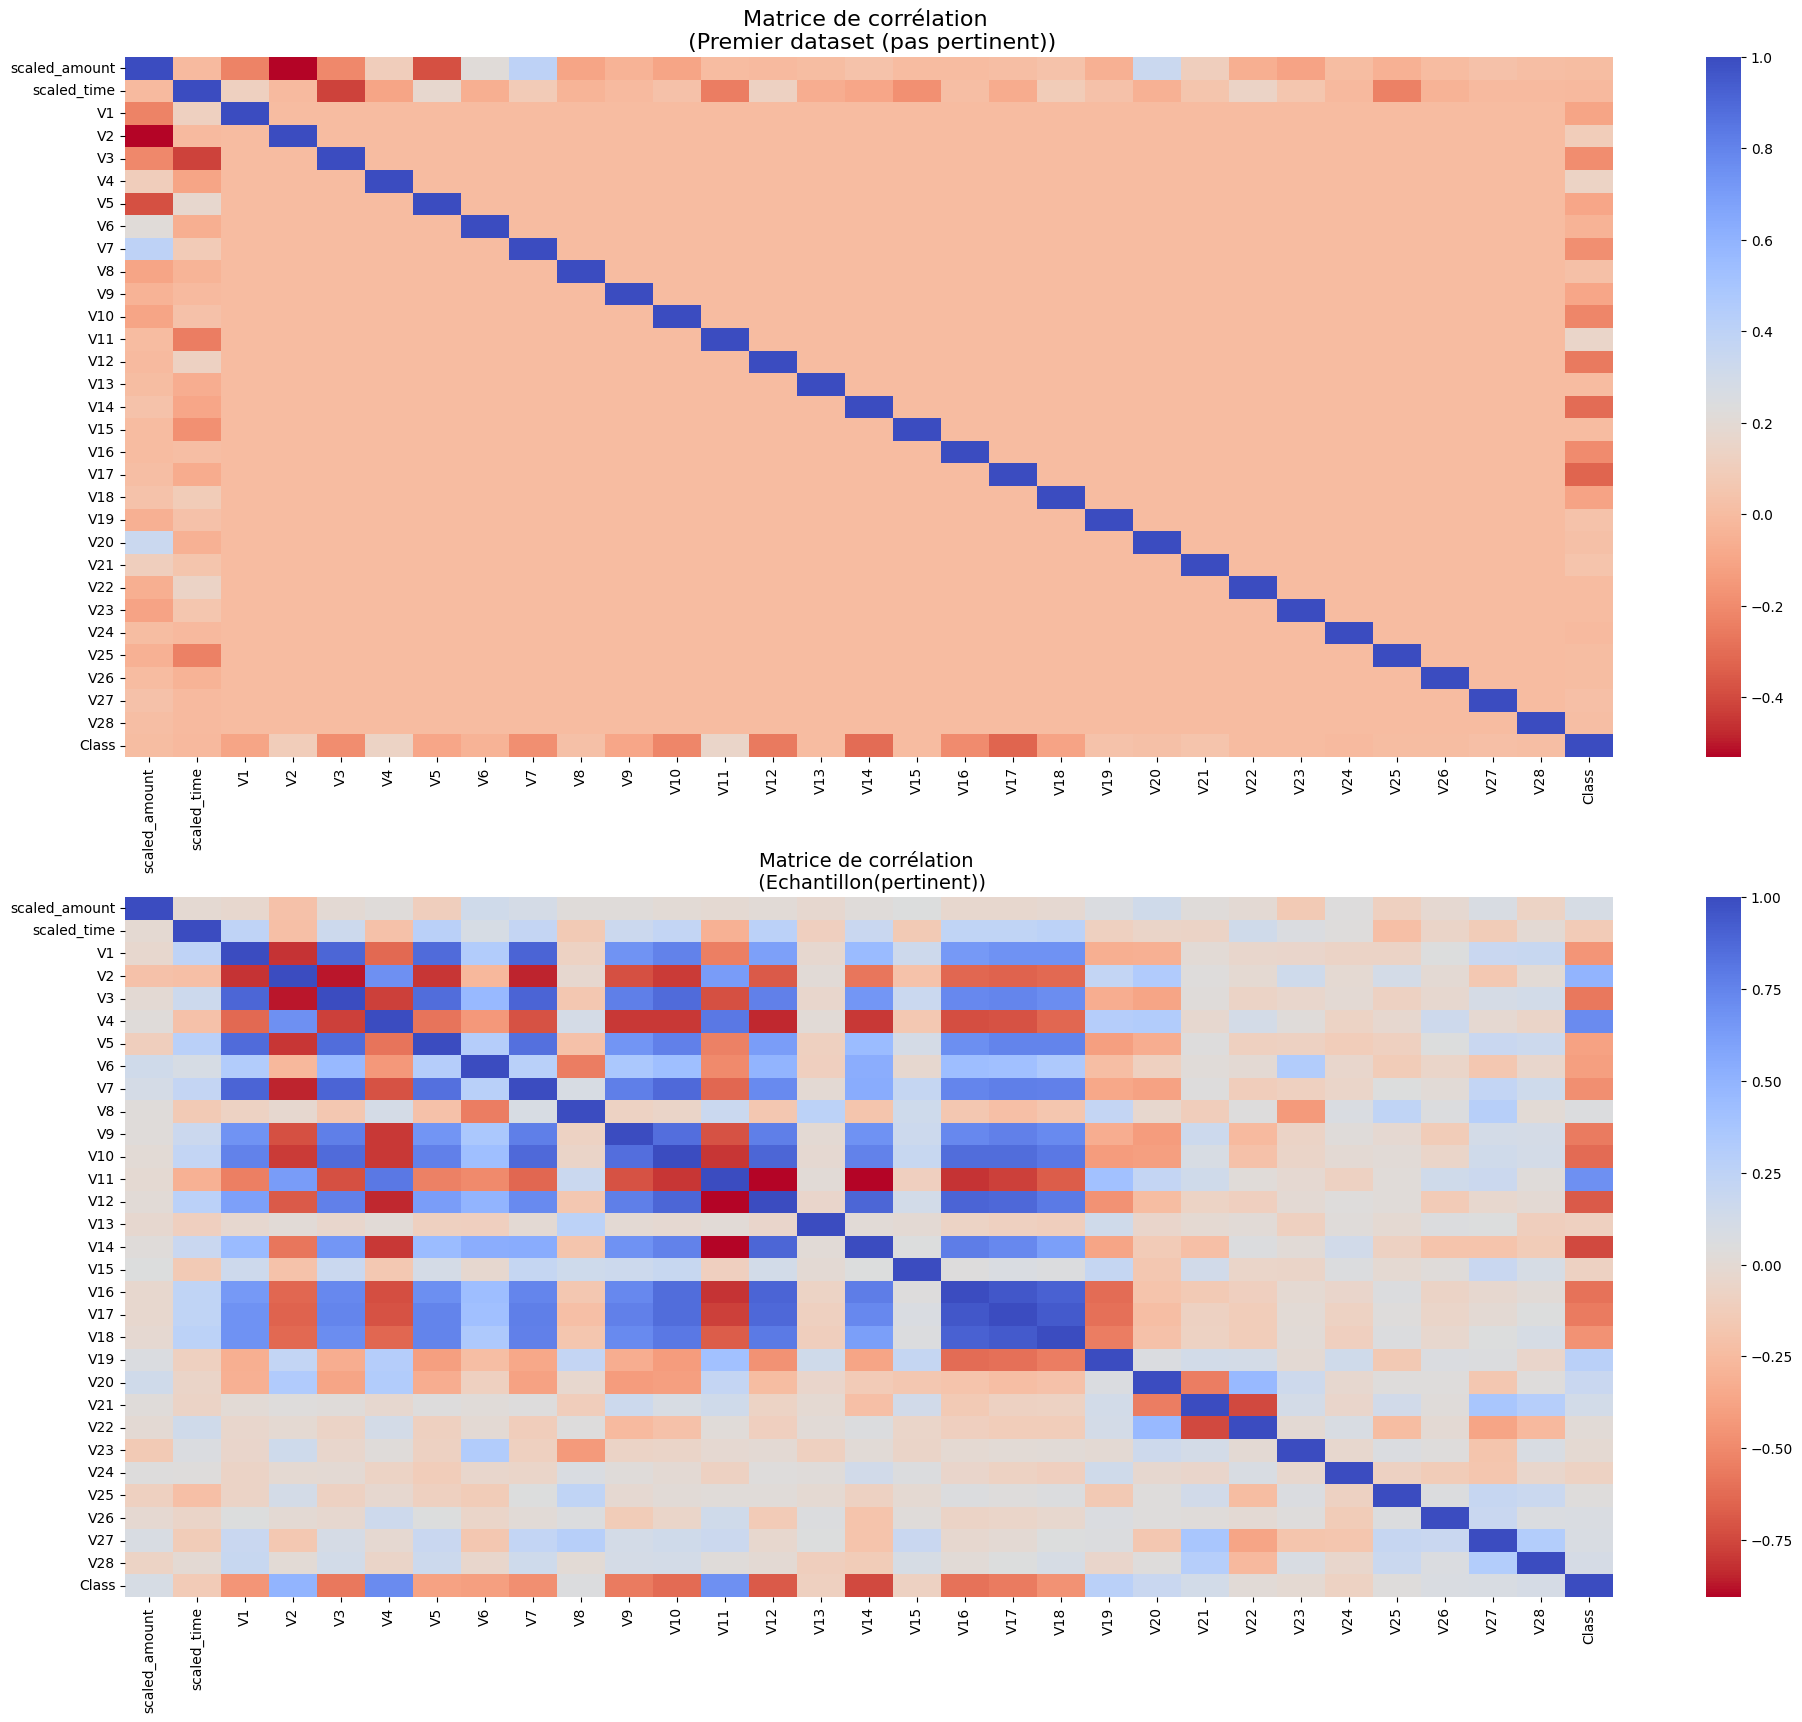

In [ ]:
# Nous nous assurons que nous utilisons le l'échantillon dans notre corrélation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Ensemble du DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matrice de corrélation \n (Premier dataset (pas pertinent))", fontsize=16)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Matrice de corrélation \n (Echantillon(pertinent))', fontsize=14)
plt.show()

Boîtes à moustache :

Nous allons réaliser les boîtes à moustache en nous focalisant sur les variables ayant une forte influence sur la variable "Class"

<ipython-input-50-aad53bca5244>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
<ipython-input-50-aad53bca5244>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
<ipython-input-50-aad53bca5244>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
<ipython-input-50-aad53bca5244>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

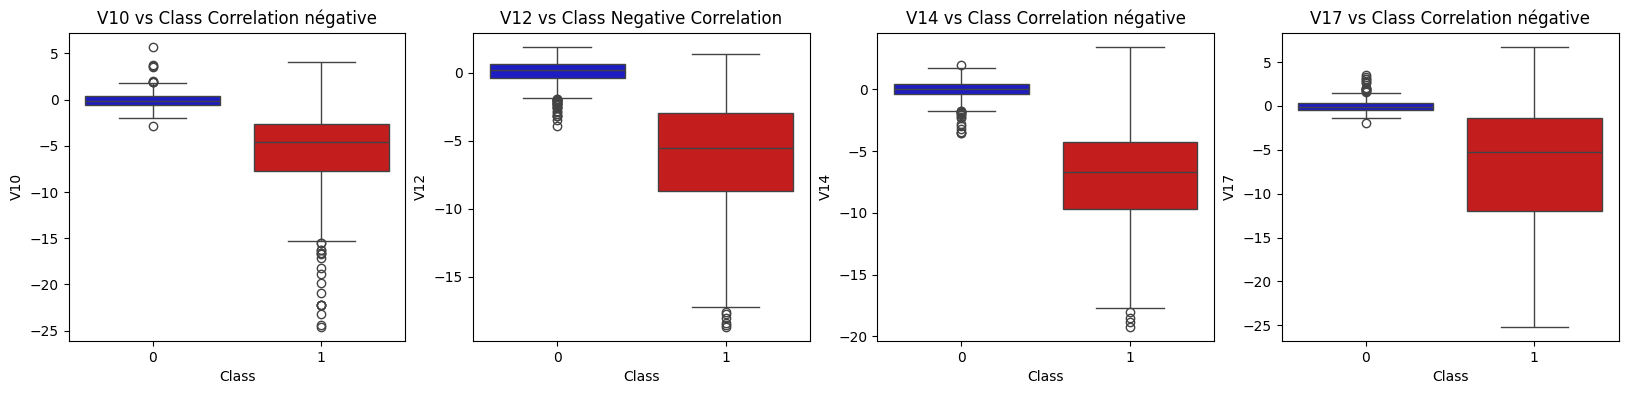

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Boxplot des corrélations négatives v10; v12; v14; v17
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class Correlation négative')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class Correlation négative')


sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V17 vs Class Correlation négative')

plt.show()

<ipython-input-51-332d07176dc8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
<ipython-input-51-332d07176dc8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
<ipython-input-51-332d07176dc8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
<ipython-input-51-332d07176dc8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be r

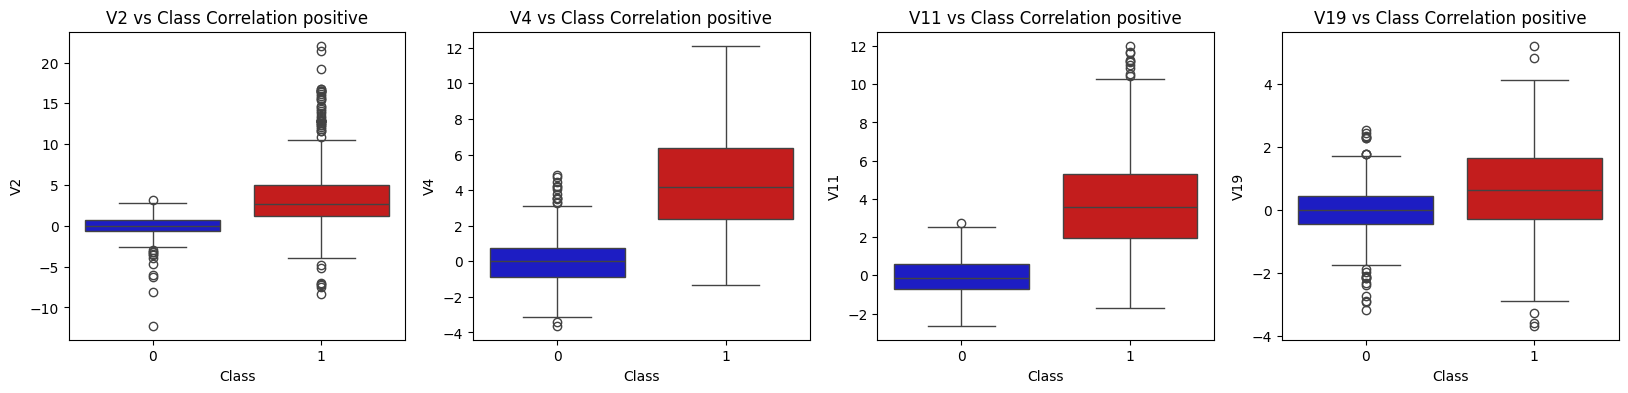

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Boxplot des corrélations positives v2; v4; v11; v19
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class Correlation positive')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Correlation positive')


sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class Correlation positive')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Correlation positive')

plt.show()

Au regard des boîtes à moustache générées, nous observons que notre échantillon présente des valeurs abérantes pour les variables fortements corrélées avec la variable ciblre "Class". Afin d'obtenir un meilleur modèle nous allons les traiter.

**Comment allons-nous procéder ?**
Nous allons utiliser la méthode d'intervalle interquartile

Pour chacunes des variables à fortes influences (corrélation) nous avons respectivement diminué :

Feature V10 Outliers for Fraud Cases: 27
Feature V12 Outliers for Fraud Cases: 4
Feature V14 Outliers for Fraud Cases: 4

NB : V17 nous pouvons nous en passer, elle ne présente pas de valeurs abérrantes pour des cas de Fraud

**Intervalle interquartile (Q3-Q1)** : est un paramètre de dispersion absolue qui correspond à l'étenude de la distribution une fois que l'on a retiré les 25% des valeurs les plus faibles et les 25% des valeurs les plus fortes. 50% des observations sont donc concentrées entre Q1 et Q3.

*Source :  [Université Paris Cité, Chapitre 4: Les paramètres de dispersion](http://grasland.script.univ-paris-diderot.fr/STAT98/stat98_4/stat98_4.htm#:~:text=%2D%20L'intervalle%20interquartile%20(Q3,concentr%C3%A9es%20entre%20Q1%20et%20Q3.)*

In [ ]:
# Retrait des valeurs aberrantes pour des cas de Fraud avec V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# Retrait des valeurs aberrantes pour des cas de Fraud avec V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Retrait des valeurs aberrantes pour des cas de Fraud avec V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.4937733551053, -18.0499976898594, -18.8220867423816]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.4311310279993, -18.5536970096458]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-22.1870885620007, -20.949191

Visualisons de nouveau les boîtes à moustache pour voir la différence avant et après la diminution des valeurs aberrantes

<ipython-input-54-44ae5fc50517>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
<ipython-input-54-44ae5fc50517>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
<ipython-input-54-44ae5fc50517>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)


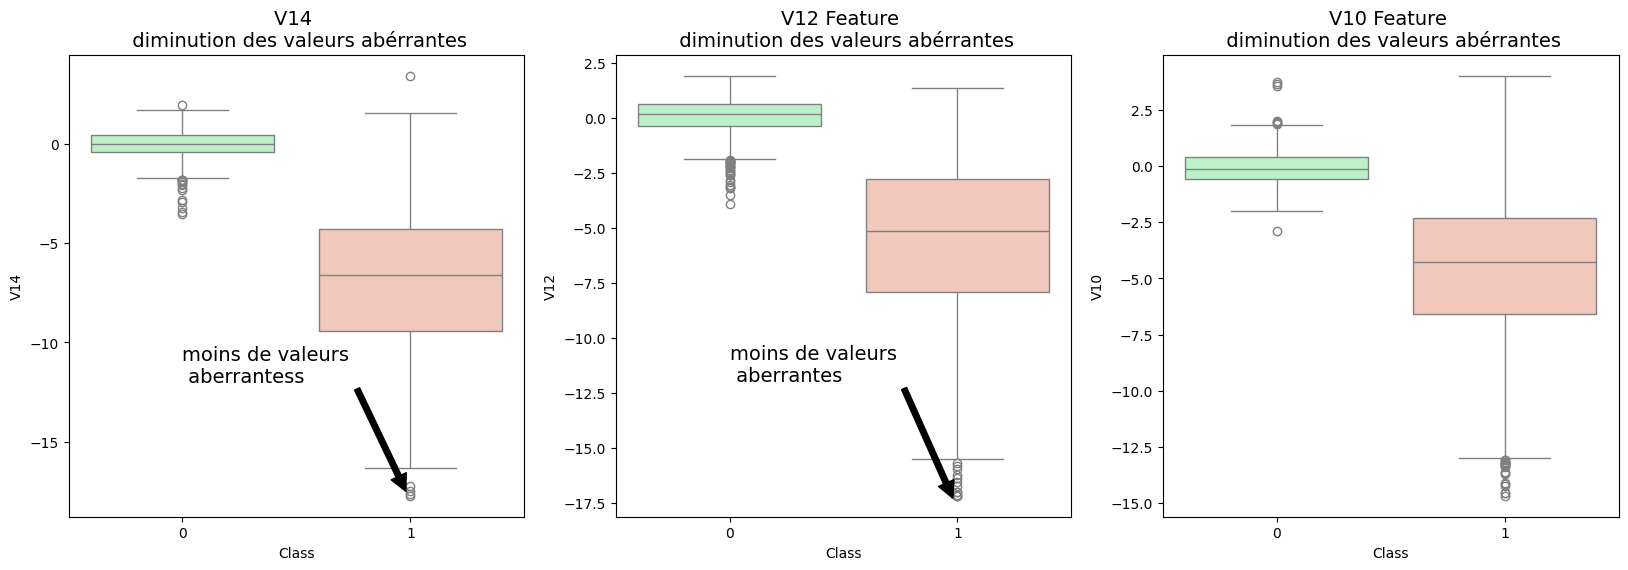

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 \n diminution des valeurs abérrantes", fontsize=14)
ax1.annotate('moins de valeurs \n aberrantess', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# V12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n diminution des valeurs abérrantes", fontsize=14)
ax2.annotate('moins de valeurs \n aberrantes', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n diminution des valeurs abérrantes", fontsize=14)
ax3.annotate('moins de valeurs \n aberrantes', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

# 3. Entraînement du modèle

Nous allons former quatre algorithmes de classification et décider lequel sera le plus efficace pour détecter les transactions frauduleuses. Au préalable, nous devons diviser nos données en ensembles de formation et de test et séparer les caractéristiques des étiquettes.

### Algorithmes :
*    **Regression logistique :** Un modèle de régression utilisé pour prédire la probabilité qu'une observation appartienne à une classe particulière. C'est un modèle linéaire qui est souvent utilisé comme référence de base dans de nombreux problèmes de classification.

*    **Méthode des k plus proches voisins:** Un algorithme de classification qui attribue une classe à une observation en fonction des classes majoritaires de ses k voisins les plus proches dans l'espace des features.

*    **Support Vector Machine :** Un algorithme de classification qui cherche à trouver l'hyperplan optimal pour séparer les données en classes. Il peut également être utilisé pour des problèmes de régression.

*    **Arbre de décision :** Un modèle de classification qui divise récursivement l'ensemble des données en sous-ensembles plus petits en fonction de caractéristiques spécifiques, en choisissant à chaque étape la caractéristique qui fournit la séparation la plus informative.

*Source : ChatGPT*

In [ ]:
# Sélection de toutes les colonnes de new_df sauf la colonne 'Class' et assignation du résultat à 'X', qui contient les features
X = new_df.drop('Class', axis=1)

# Sélection  uniquement de la colonne de 'Class' et assignation du résultat à 'y', qui contient le target
y = new_df['Class']

In [ ]:
# Division des données en ensembles d'entraînement et de test. Les données sont divisées de telle sorte que 80% sont attribuées à l'ensemble d'entraînement (X_train, y_train) et 20% à l'ensemble de test (X_test, y_test)
# 'random_state=42' garantit la reproductibilité de la division aléatoire
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convertit les données en tableaux numpy pour faciliter la manipulation
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# Les algorithmes de classification choisis
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# 4. Evaluation du modèle

In [ ]:
# Score d'entrainement
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Algorithme: ", classifier.__class__.__name__, "a un score d'entrainement de :", round(training_score.mean(), 2) * 100, "% score de précision")

Algorithme:  LogisticRegression a un score d'entrainement de : 93.0 % score de précision
Algorithme:  KNeighborsClassifier a un score d'entrainement de : 93.0 % score de précision
Algorithme:  SVC a un score d'entrainement de : 93.0 % score de précision
Algorithme:  DecisionTreeClassifier a un score d'entrainement de : 91.0 % score de précision


# 5. Optimisation du modèle

Place à l'amélioration de notre modèle, nous allons pour cela utiliser GridSearchCV pour rechercher les meilleures performances de notre modèle.

GridSearchCV : est le processus de réglage des hyperparamètres afin de déterminer les valeurs optimales pour un modèle donné. Comme mentionné ci-dessus, les performances d'un modèle dépendent largement de la valeur des hyperparamètres.

*Source : [Réglage des hyperparamètres avec GridSearchCV](https://www.mygreatlearning.com/blog/gridsearchcv/)*

In [ ]:
from sklearn.model_selection import GridSearchCV


# LRegression logistique
# Spécification d'une grille de paramètres (log_reg_params) comprenant les valeurs pour les paramètres penalty (régularisation) et C (force de régularisation).
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# La régression logistique avec les meilleurs paramètres
log_reg = grid_log_reg.best_estimator_

# Spécification d'une grille de paramètres (knears_params) comprenant les valeurs pour le nombre de voisins (n_neighbors) et l'algorithme utilisé pour calculer les voisins les plus proches
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# Les meilleurs estimateurs de KNears
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
# Spécification d'une grille de paramètres (svc_params) comprenant les valeurs pour les paramètres C (pénalisation de l'erreur) et kernel (type de noyau utilisé)
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# Les meilleurs estimateurs de SVC
svc = grid_svc.best_estimator_

# DecisionTree Classifier
# Spécification d'une grille de paramètres (tree_params) comprenant les valeurs pour les paramètres criterion (mesure de qualité de la séparation), max_depth (profondeur maximale de l'arbre) et min_samples_leaf (nombre minimal d'échantillons requis pour être une feuille).
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Les meilleurs estimateurs de DecisionTree Classifier
tree_clf = grid_tree.best_estimator_

In [ ]:
# Evaluation des performances des modèles optimisés à l'aide de la validation croisée
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Régression logistique Validation croisée Score :', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Validation croisée Score :', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Validation croisée Score :', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Validation croisée Score :', round(tree_score.mean() * 100, 2).astype(str) + '%')

Régression logistique Validation croisée Score : 93.93%
Knears Neighbors Validation croisée Score : 93.67%
Support Vector Classifier Validation croisée Score : 93.4%
DecisionTree Classifier Validation croisée Score : 93.53%


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Obtention des prédictions des modèles sur les données d'entraînement à l'aide de la validation croisée

# Les prédictions obtenues pour chaque modèle (régression logistique, k plus proches voisins, support vector classifier et arbre de décision) sont stockées dans les variables correspondantes (log_reg_pred, knears_pred, svc_pred et tree_pred).
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9721005609226234
KNears Neighbors:  0.9347709158476358
Support Vector Classifier:  0.9833748960931007
Decision Tree Classifier:  0.9321234728305287


Traçons la courbe ROC (Receiver Operating Characteristic) pour plusieurs classificateurs différents afin de comparer leurs performances en termes de taux de vrais positifs (True Positive Rate) par rapport au taux de faux positifs (False Positive Rate).

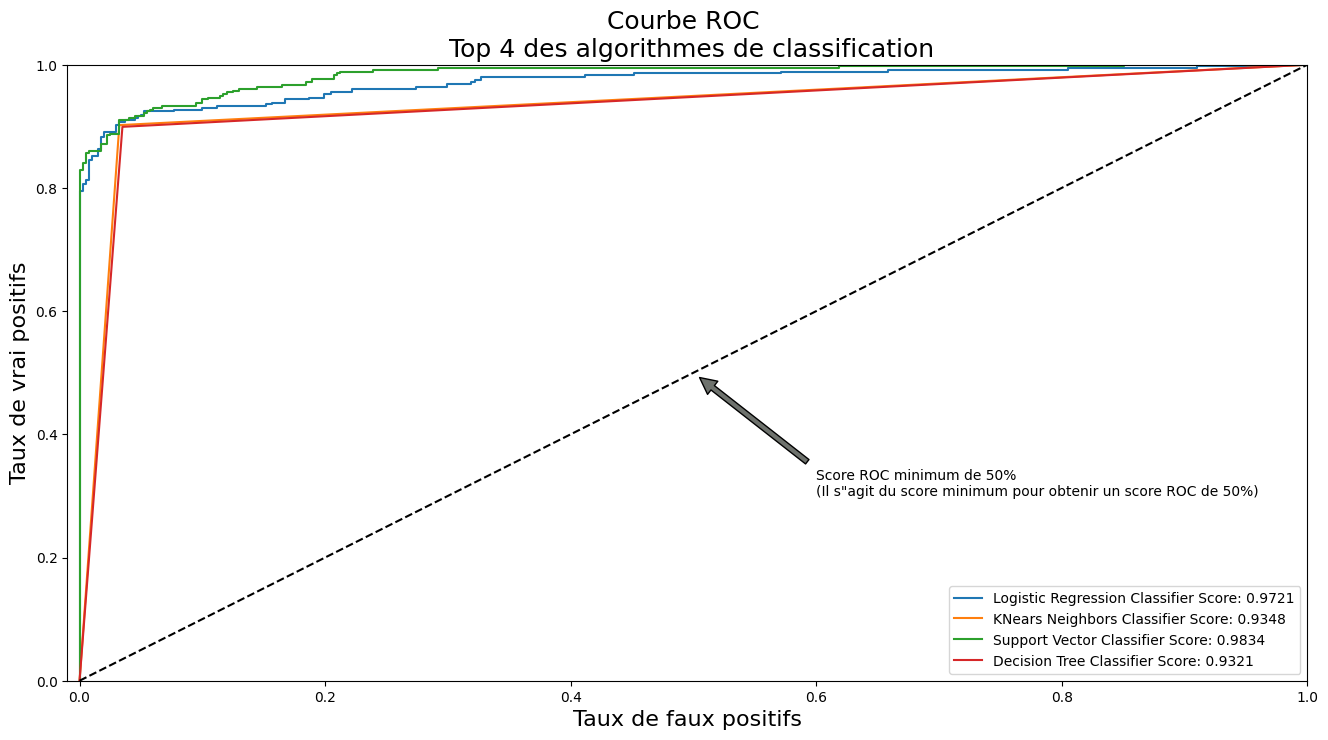

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('Courbe ROC \n Top 4 des algorithmes de classification', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('Taux de faux positifs', fontsize=16)
    plt.ylabel('Taux de vrai positifs', fontsize=16)
    plt.annotate('Score ROC minimum de 50% \n(Il s"agit du score minimum pour obtenir un score ROC de 50%)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

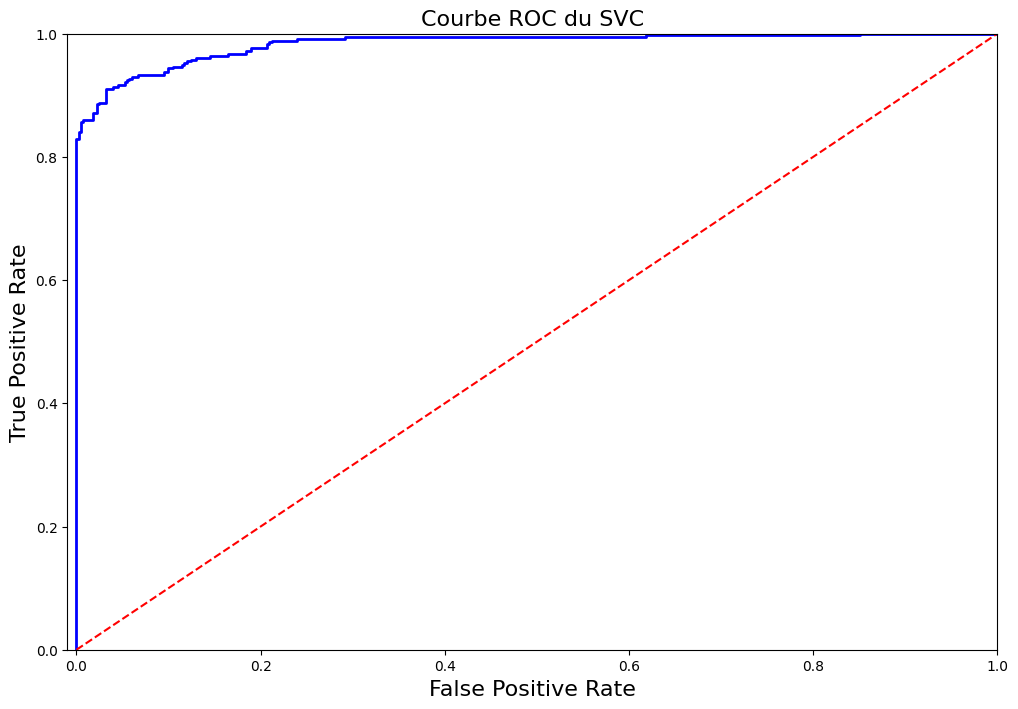

In [ ]:
def svc_roc_curve(svc_fpr, svc_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Courbe ROC du SVC', fontsize=16)
    plt.plot(svc_fpr, svc_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


svc_roc_curve(svc_fpr, svc_tpr)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, svc_pred)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = svc.predict(X_train)

# Cas de surajustement
print('---' * 45)
print('Surajustement: \n')
print('Score de Rappel: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Surajustement: 

Score de Rappel: 0.89
Precision Score: 0.98
F1 Score: 0.93
Accuracy Score: 0.94
---------------------------------------------------------------------------------------------------------------------------------------


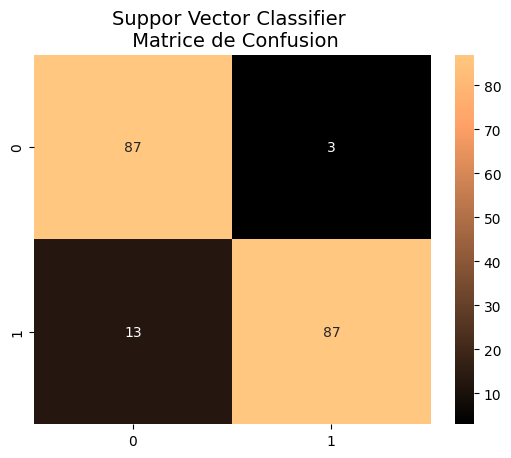

In [ ]:
from sklearn.metrics import confusion_matrix

svc_cf = confusion_matrix(y_test, y_pred_svc)

sns.heatmap(svc_cf, annot=True, cmap=plt.cm.copper)
plt.title("Suppor Vector Classifier \n Matrice de Confusion", fontsize=14)

plt.show()

# 6. Déploiement du modèle

In [ ]:
# Enregistrement du modèle

from joblib import dump

# Supposons que votre modèle est nommé 'model'
dump(svc_pred, 'Credit_Fraud.pkl')

['Credit_Fraud.pkl']